# Analysis

In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [292]:
sns.set(rc={'figure.figsize':(10,7)})
plt.style.use('seaborn-whitegrid')

In [754]:
year = 'model_new'

## Data preparation

In [755]:
f = uproot.pandas.iterate("../outputs/"+year+"/trees/*.root", "t", reportpath = True,
                          branches=['beam_energy', 'mass', 'trigger', 'procedure'])

In [756]:
dataRAW = pd.concat([j.assign(name=float(re.findall(r"\d+\.\d+", path)[0])) for path,j in f])

In [757]:
dataRAW.sort_values(by='name', ascending=True, inplace=True);

Количество уникальных `name` в `data` должно совпадать с количеством точек в сезоне

* 11 год: 40 точек
* 12 год: 16 точек
* 17 год: 34 точки
* 19 год: 44 точки
* моделирование: 38 точек

In [758]:
print("Checking:", len(dataRAW.name.unique()), 'different names in', year, 'season')

Checking: 38 different names in model_new season


Проверка типов полей датафрейма

In [759]:
dataRAW.dtypes

beam_energy    float64
mass           float64
trigger          int32
procedure        int32
name           float64
dtype: object

Проверка данных

In [760]:
dataRAW.describe()

,beam_energy,mass,trigger,procedure,name
count,62520.000000,62520.000000,62520.000000,62520.00000,62520.000000
mean,794.440979,485.246469,1.667163,2.25048,794.440979
std,122.374331,79.957691,0.753575,0.48939,122.374331
min,550.000000,-1.000000,-1.000000,1.00000,550.000000
25%,712.500000,492.421928,2.000000,2.00000,712.500000
50%,825.000000,497.737854,2.000000,2.00000,825.000000
75%,887.500000,502.998238,2.000000,3.00000,887.500000
max,1000.000000,577.296082,2.000000,3.00000,1000.000000


Проверить триггер

In [761]:
bad_trig = dataRAW.query('trigger<0')
print('Energy points with bad trigger:\n', bad_trig.name.value_counts())

Energy points with bad trigger:
 550.0     45
825.0     38
562.5     35
587.5     28
612.5     25
837.5     21
875.0     21
625.0     19
862.5     19
850.0     19
600.0     15
812.5     14
762.5     14
787.5     14
575.0     14
650.0     14
925.0     13
887.5     12
912.5     12
662.5     11
800.0     10
900.0      9
750.0      9
775.0      9
700.0      8
637.5      8
962.5      8
945.0      7
675.0      7
687.5      7
950.0      6
725.0      6
935.0      6
737.5      6
975.0      5
712.5      5
1000.0     5
987.5      4
Name: name, dtype: int64


Проверить энергии

In [762]:
bad_en = dataRAW.query('beam_energy<0')
print('Bad energy records:', bad_en.name.shape[0])

Bad energy records: 0


Удалить события с плохим триггером и энергиями (не в моделировании)

In [763]:
data = dataRAW if 'model' in year else dataRAW.query('trigger>-1&beam_energy>0')

Оставить только массы внутри окна (450,550) и без процедуры kinfit

In [764]:
data = data.query('mass>450&mass<550&procedure!=1')

In [765]:
print(data.shape[0], 'records left')

60676 records left


Удалить ненужные столбцы

In [766]:
data.drop('procedure', axis=1, inplace=True)

/home/nikitap/programs/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [767]:
data.head()

,beam_energy,mass,trigger,name
1618,550.0,489.028839,2,550.0
1639,550.0,501.318237,2,550.0
1640,550.0,473.089111,2,550.0
1641,550.0,501.844910,2,550.0
1642,550.0,501.702667,2,550.0


Добавить светимости

In [768]:
lum = pd.read_csv(f'../inputs/{year}/lum.dat')
lum.rename({'label': 'name'}, axis=1, inplace=True)
if 'err' in lum.columns:
    lum.drop(['err'], axis=1, inplace=True) #ошибка светимостей уходит в систематику
    
lum = lum.sort_values(by='name')

In [769]:
lum.tail()

,name,lum
33,950.0,5294
34,962.5,4667
35,975.0,4112
36,987.5,3640
37,1000.0,3361


Проверить данные (хорошо, если числа совпадают)

Если не совпадают, то проверить светимости на дубликаты

In [770]:
print('Records in  lum:', lum.shape[0])
print('Records in data:', data.name.unique().shape[0])

Records in  lum: 38
Records in data: 38


Объединить данные и светимость

In [771]:
data_prep = lum.merge(data, on='name')

In [772]:
def check_foo(data1, data2):
    if(data1.shape[0] == data2.shape[0]):
        print("Good.", data1.shape[0], 'rows' )
    else:
        print("WARNING. frames haven't equal shape |", data1.shape[0], 'vs', data2.shape[0], 'records')
    return

In [773]:
check_foo(data_prep, data)

Good. 60676 rows


Смотрим, в каких именно точках не совпадают `data` и `lum`

In [774]:
set1 = set(data.name.unique())
set2 = set(lum.name.unique())

(set1|set2).difference(set1&set2)

set()

### Pictures

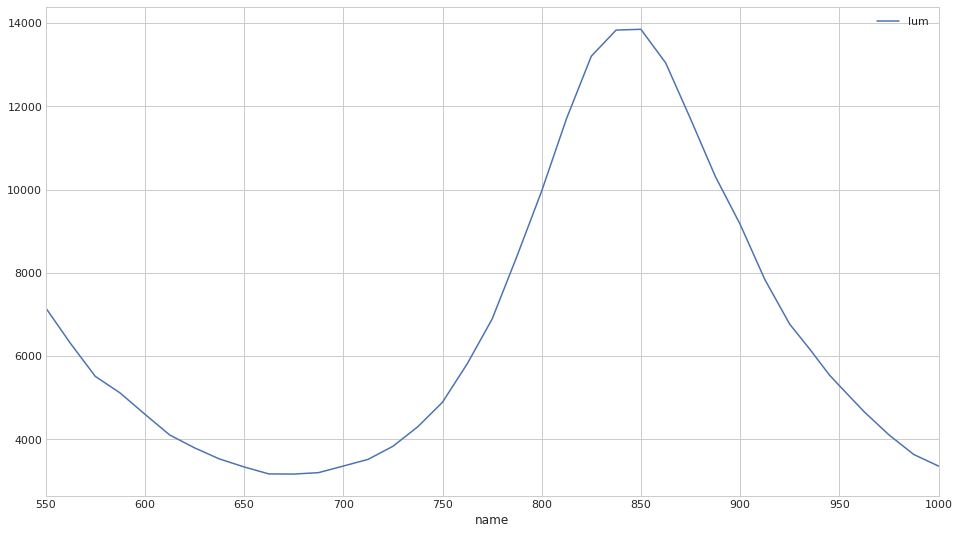

In [775]:
lum.plot(x='name', y='lum')

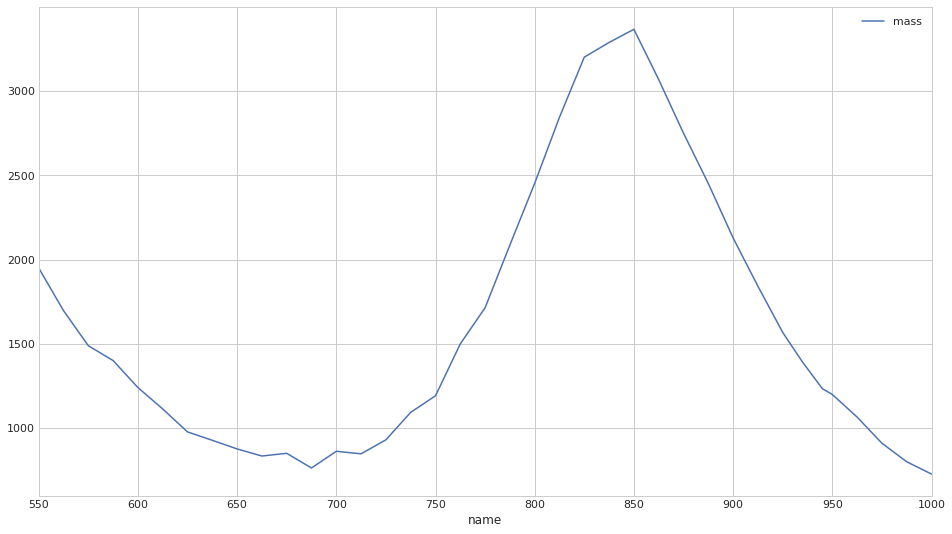

In [776]:
data_prep.groupby('name').agg({'mass':np.size}).plot()

In [777]:
data_prep.groupby('name').agg({'mass':np.size})

,mass
name,
550.0,1951.0
562.5,1698.0
575.0,1490.0
587.5,1402.0
600.0,1242.0
612.5,1115.0
625.0,979.0
637.5,929.0
650.0,878.0


Слияние точек

In [778]:
cnct = []
if year=='11':
    cnct = [([887.5, 900., 912.5, 925., 935.], 910), ([945., 950., 962.5, 975., 987.5, 1000.], 950)] #11year
if year=='12':
    cnct = [([900., 920., 936.], 920), ([950., 960., 970.,], 950), ([ 980., 990], 960)] #12 year
if year=='17':
    cnct = [([880., 890.], 885), ([900., 910.], 905), ([920., 930.], 925),
           ([937.4, 937.5, 938.3, 938.9, 939.6, 940.2, 940.8], 939)] #17 year
#     cnct = [([880., 890., 900., 910.], 900), ([920., 930., 936., 937.5], 935),
#             ([937.4, 938.3, 938.9], 938), ([939.6, 940.2, 940.8], 940),
#             ([942., 950., 960., 971.], 960), ([981., 990, 1003.5],990)] #17 year
# if year=='19': #в последний раз не сливал точки
#     cnct = [([862.5, 875.0, 887.5, 900.0, 912.5, 925], 875),([936, 945.0, 950.0, 951.1, 955.0, 962.5], 955),
#             ([975., 978.0, 987.5], 980)] #19year

In [779]:
for c in cnct:
    data_prep.name.replace(c[0], c[1], inplace=True)

OK, points have been merged

In [780]:
data_prep.tail()

,name,lum,beam_energy,mass,trigger
60671,1000.0,3361,1000.0,493.645874,2
60672,1000.0,3361,1000.0,515.456543,2
60673,1000.0,3361,1000.0,503.058228,2
60674,1000.0,3361,1000.0,505.442688,2
60675,1000.0,3361,1000.0,496.942139,2


In [781]:
check_foo(data_prep, data)

Good. 60676 rows


### Пересчитать светимости в слитых точках

In [782]:
data_prep['lume'] = data_prep.beam_energy*data_prep.lum

Проверить правильность слияния

In [783]:
#число в поле lum с количеством элементов в списке для слияния
data_prep[['lum', 'name']].\
drop_duplicates(subset=['name','lum']).groupby('name').agg({'lum':np.size}).query('lum!=1')

,lum
name,


In [784]:
new_lum = data_prep[['beam_energy', 'lum', 'lume', 'name']].drop_duplicates(subset=['lum','name']).\
groupby('name').agg({'lume':[np.sum], 'lum':[np.sum], 'beam_energy':[np.min, np.max]})

In [785]:
new_lum.shape

(38, 4)

In [786]:
new_lum['Emean'] = np.round( new_lum[('lume','sum')]/new_lum[('lum','sum')], 2)

In [787]:
new_lum.columns = ['lume', 'lum', 'dEmin', 'dEmax', 'Emean']
new_lum.drop('lume', axis=1, inplace=True)
new_lum['dEmax'] = np.abs( np.round( new_lum.dEmax-new_lum.Emean, 2) )
new_lum['dEmin'] = np.abs( np.round( new_lum.Emean - new_lum.dEmin, 2) )

In [788]:
#data.loc[641.].beam_energy.std()

In [789]:
new_lum.query('dEmin>0')

,lum,dEmin,dEmax,Emean
name,,,,


I have got new luminosity table.

Now I should join it to existing table

In [790]:
data_prep.drop(['lume', 'lum', 'beam_energy'], axis=1, inplace=True)

In [791]:
final_data = data_prep.join(new_lum, how='inner', on='name')

In [792]:
check_foo(final_data, data_prep)

Good. 60676 rows


That is good. Now I should do the analysis

In [793]:
final_data.tail()

,name,mass,trigger,lum,dEmin,dEmax,Emean
60671,1000.0,493.645874,2,3361,0.0,0.0,1000.0
60672,1000.0,515.456543,2,3361,0.0,0.0,1000.0
60673,1000.0,503.058228,2,3361,0.0,0.0,1000.0
60674,1000.0,505.442688,2,3361,0.0,0.0,1000.0
60675,1000.0,496.942139,2,3361,0.0,0.0,1000.0


----------------
## Fit

In [794]:
data2 = final_data.groupby('name')

In [795]:
dic = {}
for i in data2.groups:
    print(i)
    dic[i] = np.array( data2.get_group(i)['mass'] )

550.0
562.5
575.0
587.5
600.0
612.5
625.0
637.5
650.0
662.5
675.0
687.5
700.0
712.5
725.0
737.5
750.0
762.5
775.0
787.5
800.0
812.5
825.0
837.5
850.0
862.5
875.0
887.5
900.0
912.5
925.0
935.0
945.0
950.0
962.5
975.0
987.5
1000.0


In [796]:
import iminuit
import probfit as pf

In [797]:
plt.rcParams.update({'font.size': 18, 'figure.figsize':(16,9)})

In [798]:
mass_bound = (450, 550)

In [799]:
#2 гаусса
def constant(x):
    return 1
def two_gauss(x, mu, sigma1, sigma2, frac):
    return frac*pf.gaussian(x, mu, sigma1) + (1-frac)*pf.gaussian(x, mu, sigma2)

norm_sig = pf.rename( pf.Normalized( two_gauss, mass_bound ), ['x', 'M', '$\sigma1$', '$\sigma2$', 'f'] )
norm_bkg = pf.Normalized( constant, mass_bound )

ext_sig = pf.Extended(norm_sig, extname='$N_{sig}$')
ext_bkg = pf.Extended(norm_bkg, extname='$N_{bkg}$')

pdf = pf.AddPdf(ext_sig, ext_bkg)

MLim = (498.1, 5.0)
sigma1Lim = (6.7, 5.0)
sigma2Lim = (10., 0)
fLim = (1, 0)

# 11: 𝜎1=(4.49, 0.27) , 𝜎2=(10.1, 1.), 𝑓=(0.68, 0.07), M=(497.299, 0.098)
# 12: 𝜎1=(5.26, 0.30) , 𝜎2=(14.42, 3.87), 𝑓=(0.86, 0.06), M=(498.33, 0.27)
# mod_old: 𝜎1=(5.43, 0.10) , 𝜎2=(12.68, 0.25), 𝑓=(0.58, 0.02), M=(497.05, 0.04)
# mod_new: 𝜎1=(5.35, 0.07) , 𝜎2=(12.74, 0.17), 𝑓=(0.57, 0.02), M=(498.00, 0.03)
limits = {
    "limit_M": [MLim[0]-MLim[1], MLim[0]+MLim[1]],
    "limit_$\sigma1$": [sigma1Lim[0] - sigma1Lim[1], sigma1Lim[0] + sigma1Lim[1]],
    "limit_$\sigma2$": [sigma2Lim[0] - sigma2Lim[1], sigma2Lim[0] + sigma2Lim[1]],
    "limit_$N_{sig}$": [0, 100000],
    "limit_$N_{bkg}$": [0, 2000],
    "limit_f": [fLim[0]-fLim[1], fLim[0]+fLim[1]]
}
errors = {
    "error_M": 1,
    "error_$\sigma1$": 0.1,
    "error_$\sigma2$": 0.,
    "error_$N_{sig}$": 0.3,
    "error_$N_{bkg}$": 0.1,
    "error_f": 0.
}

pf.describe(pdf)

['x', 'M', '$\\sigma1$', '$\\sigma2$', 'f', '$N_{sig}$', '$N_{bkg}$']

In [803]:
def fitter(dic, nbins, energy, binnedLik=False, simple_plot=True):
    
    likelihood = pf.UnbinnedLH(pdf, dic, extended=True, extended_bound=mass_bound) if not(binnedLik) else \
    pf.BinnedLH(pdf, dic, int(nbins*(mass_bound[1]-mass_bound[0])/100.), bound=mass_bound, extended=True)
    
    initial_par_values = {"M": 497.6, "$\sigma1$": 4.26, "$N_{sig}$": np.size(dic),
                          "$\sigma2$": 11.16, "f": 0.5, "$N_{bkg}$": 1}
    mt = iminuit.Minuit(likelihood, **initial_par_values, **errors, **limits, pedantic=False)
    mt.migrad();
        
    if simple_plot:
        likelihood.draw(minuit=mt) if binnedLik else likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound)
    else:
        fig = plt.figure(figsize=(16, 10), dpi= 80)
        grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

        # Define the axes
        ax_main = fig.add_subplot(grid[:-1, :])
        ax_main.grid(ls=':')
        box_1 = {'facecolor':'black', 'boxstyle': 'round'}

        if binnedLik:
            likelihood.draw(minuit=mt, print_par=True);
        else:
            likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound, print_par=True)

        plt.tick_params(labelsize=20);
        plt.xlabel('invariant mass, MeV', fontsize=20)
        plt.ylabel('number of events', fontsize=20)

        # this is an inset axes over the main axes
        ax_bottom = fig.add_subplot(grid[-1, :], xticklabels=[])
        ax_bottom.grid(ls=':')
        likelihood.draw_residual(minuit=mt) if binnedLik else \
        likelihood.draw_residual(minuit=mt, bins=nbins, bound=mass_bound)
    
        plt.savefig(f'../outputs/{year}/figures/fit_e{energy}.pdf')
    return mt, likelihood

In [804]:
itr = iter(dic)

In [805]:
fit_frame = pd.DataFrame(columns=[ 'M', 'S1', 'S2', 'f', 'N', 'C', 
                                  'Merr', 'S1err', 'S2err', 'ferr', 'Nerr', 'Cerr'])

In [806]:
i = next(itr)
print('Label:', i)

Label: 550.0


Migrad quality: True
Real: 1951 Found: 1951.0546011177337


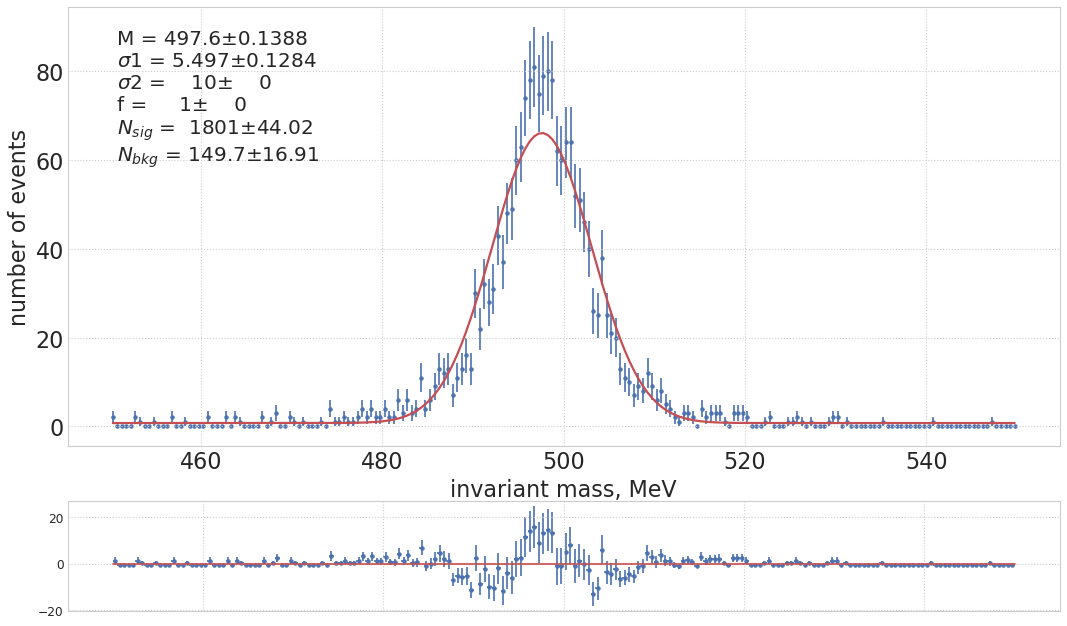

In [807]:
dicx = dic[i]#final_data.mass.values#dic[i]#
# dicx = np.hstack((dic[862.5],dic[887.5],dic[900]))
mt, lik = fitter(dicx, 200, i, False, False)
fit_frame.loc[i] = mt.values.values() + mt.errors.values()
print("Migrad quality:", mt.migrad_ok())
print( 'Real:', np.size(dicx), 'Found:', mt.values['$N_{sig}$'] + mt.values['$N_{bkg}$'] )

In [721]:
fit_frame.tail(20)

,M,S1,S2,f,N,C,Merr,S1err,S2err,ferr,Nerr,Cerr
name,,,,,,,,,,,,
800.0,497.209899,8.300000,10.0,1.0,257.442851,44.556088,0.601053,0.100000,0.0,0.0,17.429929,9.534041
812.5,497.201776,8.080625,10.0,1.0,383.189855,36.799837,0.451128,0.414326,0.0,0.0,20.921169,9.554107
825.0,497.933036,7.871771,10.0,1.0,281.110019,24.874500,0.515703,0.546761,0.0,0.0,18.325343,8.918627
837.5,497.090216,8.100000,10.0,1.0,141.654552,12.351760,0.752630,0.100000,0.0,0.0,12.560748,5.334202
850.0,497.938786,6.783533,10.0,1.0,68.873023,23.135388,0.976194,1.282834,0.0,0.0,10.144322,7.558918
862.5,498.629996,6.330000,10.0,1.0,25.404213,19.601118,0.057569,0.100000,0.0,0.0,5.826216,5.304643
875.0,500.656159,6.700000,10.0,1.0,28.411684,20.588947,2.350814,0.100000,0.0,0.0,6.930951,6.340460
887.5,498.629878,6.330000,10.0,1.0,11.502657,14.496969,0.056699,0.100000,0.0,0.0,4.165385,4.510513
900.0,498.570000,6.330000,10.0,1.0,9.217894,6.782788,0.046408,0.100000,0.0,0.0,3.370235,2.986996


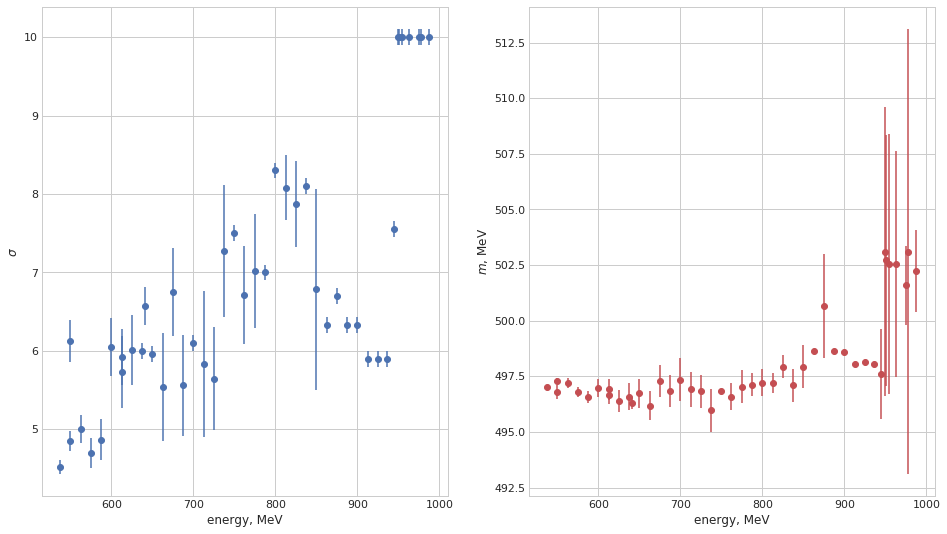

In [722]:
plt.subplot(1, 2, 1)
plt.errorbar(data=fit_frame, x=fit_frame.index, y='S1', yerr='S1err', fmt='o')
plt.xlabel('energy, MeV');
plt.ylabel('$\\sigma$');
plt.subplot(1, 2, 2)

plt.errorbar(x=fit_frame.index, y=fit_frame.M, yerr=fit_frame.Merr, fmt='or')
plt.xlabel('energy, MeV');
plt.ylabel('$m$, MeV');

### Some notes:
none

## Анализ $\sigma$

### 19 год

В точках 550 и 550.1 принципиально различается ширина ( 4.8 vs 6.12 )

В 19 году взял группами точки по энергии и посмотрел их $\sigma$, видно, что ширина растёт вместе с энергией

In [634]:
np.round(fit_frame.S1err.values, 2)

array([0.13, 0.16, 0.16, 0.18, 0.19, 0.25, 0.21, 0.23, 0.26, 0.28, 0.31,
       0.31, 0.31, 0.32, 0.32, 0.3 , 0.31, 0.29, 0.25, 0.25, 0.21, 0.2 ,
       0.21, 0.2 , 0.2 , 0.21, 0.24, 0.27, 0.31, 0.47, 0.44, 0.42, 0.59,
       0.55, 0.56, 0.66, 0.75, 0.25])

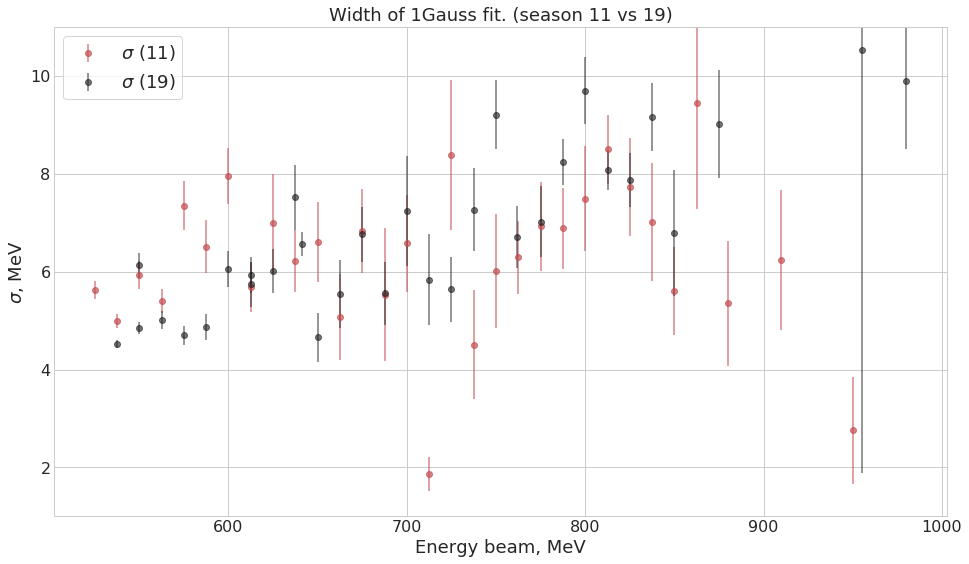

In [651]:
en19_an  = [537.5, 550. , 550.1, 562.5, 575. , 587.5, 600. , 612.5, 612.6,
       625. , 637.5, 641. , 650. , 662.5, 675. , 687.5, 700. , 712.5,
       725. , 737.5, 750. , 762. , 775. , 787.5, 800. , 812.5, 825. ,
       837.5, 850. , 875. , 955. , 980. ]
sigma19_an = [ 4.52,  4.85,  6.13,  5.01,  4.7 ,  4.87,  6.05,  5.74,  5.93,
        6.02,  7.52,  6.57,  4.66,  5.54,  6.76,  5.56,  7.24,  5.83,
        5.64,  7.27,  9.21,  6.71,  7.02,  8.25,  9.7 ,  8.08,  7.87,
        9.16,  6.79,  9.02, 10.53,  9.9 ]
dsigma19_an = [0.09, 0.13, 0.26, 0.18, 0.19, 0.26, 0.37, 0.46, 0.36, 0.45, 0.67,
       0.24, 0.5 , 0.69, 0.56, 0.64, 1.13, 0.93, 0.66, 0.84, 0.71, 0.63,
       0.73, 0.47, 0.69, 0.41, 0.55, 0.7 , 1.28, 1.1 , 8.64, 1.39]

enMC_an = [ 550. ,  562.5,  575. ,  587.5,  600. ,  612.5,  625. ,  637.5,
        650. ,  662.5,  675. ,  687.5,  700. ,  712.5,  725. ,  737.5,
        750. ,  762.5,  775. ,  787.5,  800. ,  812.5,  825. ,  837.5,
        850. ,  862.5,  875. ,  887.5,  900. ,  912.5,  925. ,  935. ,
        945. ,  950. ,  962.5,  975. ,  987.5, 1000. ]
sigmaMC_an = [5.5 , 5.87, 5.98, 6.3 , 6.23, 6.79, 6.33, 7.3 , 7.29, 7.54, 7.32,
       7.12, 7.39, 7.85, 7.59, 7.94, 7.64, 8.14, 7.99, 8.52, 8.4 , 8.44,
       8.51, 8.3 , 8.73, 8.77, 8.87, 8.3 , 8.95, 8.55, 9.21, 8.9 , 9.25,
       8.94, 9.4 , 9.67, 8.87, 8.95]
dsigmaMC_an = [0.12, 0.15, 0.17, 0.17, 0.21, 0.2 , 0.25, 0.29, 0.26, 0.34, 0.27,
       0.24, 0.32, 0.27, 0.33, 0.27, 0.23, 0.24, 0.23, 0.2 , 0.19, 0.18,
       0.15, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.23, 0.28, 0.24, 0.3 ,
       0.26, 0.29, 0.37, 0.36, 0.36]

enMCold_an = [ 550. ,  562.5,  575. ,  587.5,  600. ,  612.5,  625. ,  637.5,
        650. ,  662.5,  675. ,  687.5,  700. ,  712.5,  725. ,  737.5,
        750. ,  762.5,  775. ,  787.5,  800. ,  812.5,  825. ,  837.5,
        850. ,  862.5,  875. ,  887.5,  900. ,  912.5,  925. ,  935. ,
        945. ,  950. ,  962.5,  975. ,  987.5, 1000. ]
sigmaMCold_an = [ 5.85,  6.39,  6.24,  6.99,  6.54,  6.85,  6.17,  7.27,  7.29,
        7.7 ,  7.3 ,  7.76,  7.34,  7.22,  7.45,  7.84,  8.52,  8.05,
        8.02,  8.09,  8.5 ,  8.39,  8.54,  8.37,  9.37,  8.94,  9.12,
        8.72,  8.85,  8.73,  8.95,  9.16,  8.8 ,  9.12, 10.23,  9.56,
        9.83, 10.53]
dsigmaMCold_an = [0.13, 0.16, 0.16, 0.18, 0.19, 0.25, 0.21, 0.23, 0.26, 0.28, 0.31,
       0.31, 0.31, 0.32, 0.32, 0.3 , 0.31, 0.29, 0.25, 0.25, 0.21, 0.2 ,
       0.21, 0.2 , 0.2 , 0.21, 0.24, 0.27, 0.31, 0.47, 0.44, 0.42, 0.59,
       0.55, 0.56, 0.66, 0.75, 0.25]

en11_an = [525. , 537.5, 550. , 562.5, 575. , 587.5, 600. , 612.5, 625. ,
       637.5, 650. , 662.5, 675. , 687.5, 700. , 712.5, 725. , 737.5,
       750. , 762.5, 775. , 787.5, 800. , 812.5, 825. , 837.5, 850. ,
       862.5, 880. , 910. , 950. ]
sigma11_an = [5.63, 4.99, 5.93, 5.4 , 7.35, 6.51, 7.95, 5.69, 6.99, 6.22, 6.6 ,
       5.07, 6.83, 5.53, 6.58, 1.87, 8.38, 4.51, 6.01, 6.29, 6.93, 6.89,
       7.49, 8.5 , 7.73, 7.02, 5.61, 9.45, 5.35, 6.24, 2.76]
dsigma11_an = [0.18, 0.15, 0.28, 0.25, 0.5 , 0.54, 0.57, 0.51, 1.01, 0.63, 0.82,
       0.88, 0.85, 1.36, 0.99, 0.35, 1.53, 1.12, 1.16, 0.74, 0.91, 0.83,
       1.07, 0.7 , 1.01, 1.21, 0.9 , 2.16, 1.27, 1.43, 1.09]

df_sigma_an = pd.DataFrame({'emin':emin_an, 'emax':emax_an, 'sigma':sigma_an, 'ds': dsigma_an})
df_sigma_an['emean'] = (df_sigma_an.emin + df_sigma_an.emax)/2.
df_sigma_an['deup'] = df_sigma_an.emean - df_sigma_an.emin
# plt.errorbar(x=enMC_an, y=sigmaMC_an, yerr=dsigmaMC_an, fmt='o', alpha=0.8, label='$\sigma$ (MC)')
# plt.errorbar(x=enMCold_an, y=sigmaMCold_an, yerr=dsigmaMCold_an, alpha=0.8, fmt='oc', label='$\sigma$ (MC_old)')
plt.errorbar(x=en11_an, y=sigma11_an, yerr=dsigma11_an, fmt='or', alpha=0.7, label='$\sigma$ (11)')
plt.errorbar(x=en19_an, y=sigma19_an, yerr=dsigma19_an, fmt='ok', alpha=0.6, label='$\sigma$ (19)')
plt.legend(fontsize=18, frameon=True);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.ylim(1, 11)
plt.xlabel('Energy beam, MeV', fontsize=18);
plt.ylabel('$\sigma$, MeV', fontsize=18);
plt.title('Width of 1Gauss fit. (season 11 vs 19)', fontsize=18);
plt.savefig('sigma3.pdf')

Возникает гипотеза (ещё и с учётом того факта, что на большой статистике данные описываются не идеально) добавить ещё один гаусс. Посмотрим, что из этого выйдет.

Повторю распределение сигм по аналогии с картинкой выше

<ErrorbarContainer object of 3 artists>

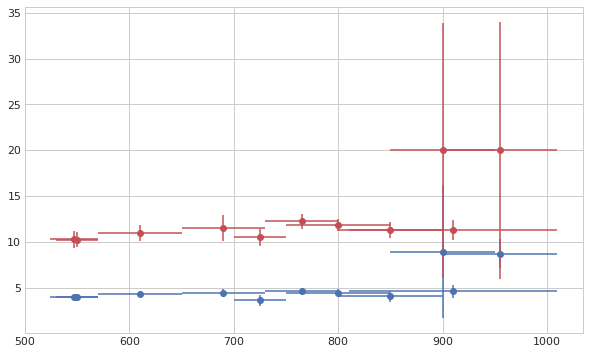

In [552]:
plt.rcParams.update({'font.size': 18, 'figure.figsize':(10,6)})
emin_an  = [524, 570, 650, 730, 800, 900, 850, 750, 700, 530, 810]
emax_an  = [570, 650, 730, 800, 900, 1010, 950, 850, 750, 570, 1010]
sigma1_an = [4.02, 4.31, 4.44, 4.66, 4.08, 8.724847949065675, 8.952093654550044, 4.509152675111134, 3.6841658856535178, 4.01709961911671, 4.628942053127934]
dsigma1_an = [0.13, 0.18, 0.44, 0.39, 0.55, 1.590062670581002, 7.270944904440277, 0.3453623743108212, 0.6048651400716212, 0.1190920659859942, 0.7016815273028718]
sigma2_an = [10.3, 10.98, 11.55, 12.25, 11.34, 19.995900427431625, 19.999882612152, 11.866375420268561, 10.53279261428423, 10.283255759137344, 11.339313291171166]
dsigma2_an = [0.9, 0.85, 1.42, 0.81, 0.89, 13.996992016425061, 13.933962567163773, 0.6617076556061905, 0.9474962757272731, 0.8289418695468278, 1.1023824322696134]
frac12_an = [3.92, 2.31, 1.76, 0.88, 0.64, 2.728843351319719, 6.911293728105318, 0.8379169741736125, 0.7006647553677061, 3.9196405944377877, 0.62839843050261]
df_sigma_an = pd.DataFrame({'emin':emin_an, 'emax':emax_an, 'sigma1':sigma1_an, 'ds1': dsigma1_an, 
                            'sigma2':sigma2_an, 'ds2': dsigma2_an, 'frac': frac12_an})
df_sigma_an['emean'] = (df_sigma_an.emin + df_sigma_an.emax)/2.
df_sigma_an['deup'] = df_sigma_an.emean - df_sigma_an.emin
plt.errorbar(data=df_sigma_an, x='emean', y='sigma1', xerr='deup', yerr='ds1', fmt='ob')
plt.errorbar(data=df_sigma_an, x='emean', y='sigma2', xerr='deup', yerr='ds2', fmt='or')

Видно, что каждая из сигм практически не сдвигается. Но видно, что на малом объёме данных ширины начинают расплываться (заметно при высоких энергиях)

Зафиксирую ширины на средних без учёта выпавших точек

In [238]:
print('Sigma1:', df_sigma_an.drop([5,6]).sigma1.mean() )
print('Sigma2:', df_sigma_an.drop([5,6]).sigma2.mean() )

Sigma1: 4.261040025889923
Sigma2: 11.160193009429035


Тогда проверяю предположение, что $\sigma$ в случае одного гаусса меняется из-за того, что меняется доля событий под узким и широким гауссами меняется с энергией

<ErrorbarContainer object of 3 artists>

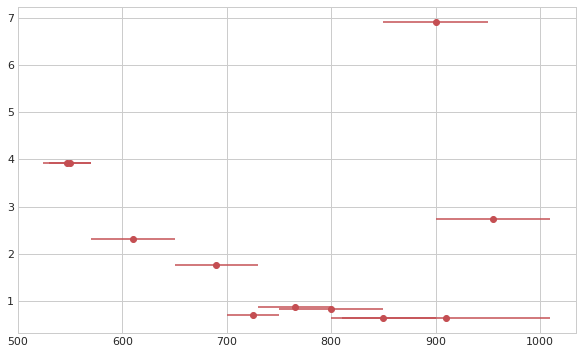

In [314]:
plt.errorbar(data=df_sigma_an, x='emean', y='frac', xerr='deup', fmt='or')

Теперь 2 гаусса для моделирования (`model_new`)

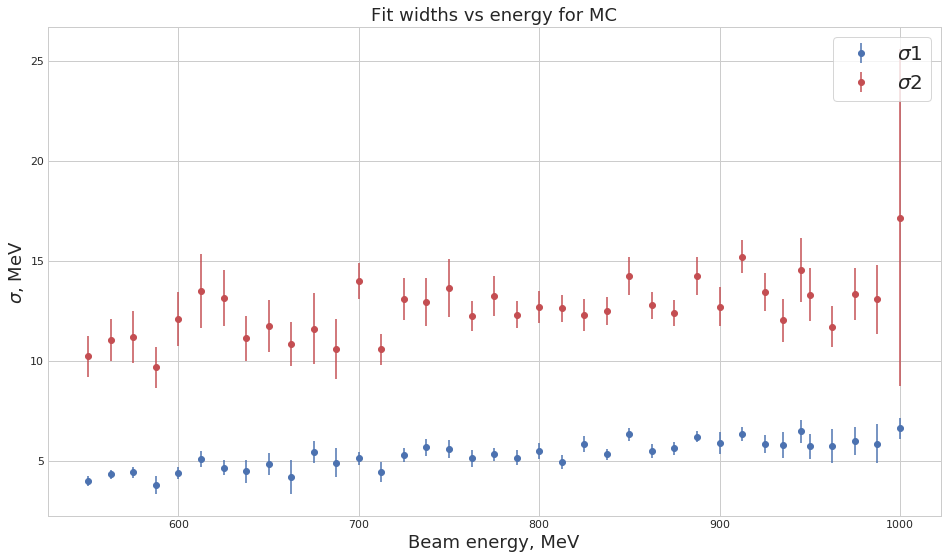

In [194]:
en_an = [ 550. ,  562.5,  575. ,  587.5,  600. ,  612.5,  625. ,  637.5,
        650. ,  662.5,  675. ,  687.5,  700. ,  712.5,  725. ,  737.5,
        750. ,  762.5,  775. ,  787.5,  800. ,  812.5,  825. ,  837.5,
        850. ,  862.5,  875. ,  887.5,  900. ,  912.5,  925. ,  935. ,
        945. ,  950. ,  962.5,  975. ,  987.5, 1000. ]
s1_an = [4.00928888, 4.33747255, 4.43559649, 3.803059  , 4.423181  ,
       5.1014904 , 4.66565474, 4.5045961 , 4.87810257, 4.1960529 ,
       5.43876272, 4.91843674, 5.14132747, 4.45975828, 5.31429813,
       5.69505078, 5.60314509, 5.14196975, 5.3540354 , 5.16952826,
       5.50877517, 4.94773543, 5.86872395, 5.33462472, 6.33305366,
       5.50748813, 5.64094449, 6.22043922, 5.8916277 , 6.35738374,
       5.86313576, 5.82890009, 6.48632741, 5.73844622, 5.75707775,
       6.0104084 , 5.87187928, 6.64138695]
s2_an = [10.24281036, 11.05319352, 11.18820377,  9.68060542, 12.08471558,
       13.48858781, 13.14961493, 11.13335416, 11.74951692, 10.83995468,
       11.62019776, 10.61195066, 13.99189698, 10.58376123, 13.09259816,
       12.95582443, 13.64101323, 12.22498239, 13.24488383, 12.3034521 ,
       12.69676957, 12.62291336, 12.27461984, 12.50987221, 14.22699406,
       12.77836884, 12.39655738, 14.23327043, 12.70892288, 15.21270754,
       13.44290652, 12.03170836, 14.54893378, 13.31082015, 11.72120822,
       13.3503376 , 13.0830581 , 17.15999921]
s1err_an = [0.24420247, 0.23628817, 0.2793554 , 0.43500637, 0.30562574,
       0.41426316, 0.36829545, 0.57240212, 0.55104936, 0.83858414,
       0.54760894, 0.72628265, 0.32523255, 0.51859386, 0.3644784 ,
       0.43592776, 0.44839775, 0.42269701, 0.32609865, 0.3645667 ,
       0.37670574, 0.36108701, 0.38803313, 0.29671017, 0.31075945,
       0.34238496, 0.33784375, 0.2866558 , 0.54865994, 0.35272085,
       0.43615359, 0.64643721, 0.55803832, 0.61537946, 0.86046785,
       0.71916831, 0.972075  , 0.51998215]
s2err_an = [1.02206463, 1.06032287, 1.28551181, 1.00666387, 1.33649728,
       1.83713476, 1.38658335, 1.13404142, 1.28373445, 1.08777375,
       1.78985585, 1.48944632, 0.89674085, 0.7724873 , 1.03681978,
       1.19733482, 1.46254629, 0.7502984 , 0.97471297, 0.6738531 ,
       0.78451445, 0.65602477, 0.80038106, 0.69198662, 0.94256228,
       0.66889848, 0.66153967, 0.94133285, 0.96653921, 0.84317584,
       0.94040895, 1.08274286, 1.57935263, 1.31951827, 1.03343693,
       1.29964889, 1.72233654, 8.39968307]
plt.errorbar(x=en_an, y=s1_an, yerr=s1err_an, fmt='ob', label='$\sigma1$')
plt.errorbar(x=en_an, y=s2_an, yerr=s2err_an, fmt='or', label='$\sigma2$')
plt.legend(frameon=True, fontsize=20);
plt.xlabel('Beam energy, MeV', fontsize=18);
plt.title('Fit widths vs energy for MC', fontsize=18)
plt.ylabel('$\sigma$, MeV', fontsize=18);
# plt.savefig('4.pdf')

По сигме всё более-менее хорошо, а вот следующее распределение по отношению событий в гауссах смущает.

Возможно это из-за каких-то разногласий моделирования и эксперимента, хотелось бы верить, но неизвестно

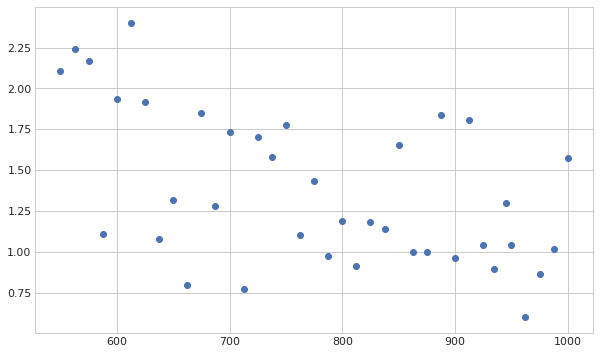

In [554]:
frac_an = [2.1047093 , 2.24281089, 2.16611316, 1.10671026, 1.93781416,
       2.39827954, 1.91504091, 1.07766751, 1.31920011, 0.79416602,
       1.84898383, 1.27802379, 1.73464467, 0.7721512 , 1.70095568,
       1.58280159, 1.77529039, 1.09981627, 1.43251272, 0.97705235,
       1.18825784, 0.9150671 , 1.18416207, 1.14115352, 1.6519543 ,
       0.99945712, 1.00099901, 1.83883042, 0.96433868, 1.8047252 ,
       1.04416522, 0.89545267, 1.29761692, 1.0409458 , 0.60057145,
       0.86444899, 1.01426618, 1.57182104]
plt.scatter(en_an, frac_an)

Смущает распределение по отношению гауссов, поэтому зафиксирую все параметры гауссов из полного распределения:

$\sigma_1 = 4.178 \pm 0.096$ , $\sigma_2 = 11.06 \pm 0.42$, $ f = 0.67 \pm 0.02$

### 17 год

Распределение по всем точкам даёт 
$\sigma_1 = 5.77 \pm 0.56$, $\sigma_2 = 13.44 \pm 2.12$, $f = 0.61 \pm 0.1 $, $M = 498.49 \pm 0.23$

### 11 год

Распределение по всем точкам даёт $\sigma_1 = 4.49 \pm 0.27$ , $\sigma_2 = 10.1 \pm 1.$, $ f = 0.68 \pm 0.07$. 

Я взял данные значения и разрешил им варьироваться в пределах ошибки

### 12 год

$\sigma_1 = 5.26 \pm 0.30$ , $\sigma_2 = 14.42 \pm 3.87$, $ f = 0.86 \pm 0.06$, $ M = 498.33 \pm 0.27$

### Model Old

$\sigma_1 = 5.43 \pm 0.10$ , $\sigma_2 = 12.68 \pm 0.25$, $ f = 0.58 \pm 0.02$, $ M = 497.05 \pm 0.04$

# Save fit info

In [723]:
fit_frame.to_csv(f'../outputs/{year}/tables/fit_frame.csv')

In [724]:
#mt.matrix(correlation=True)
#mt.draw_profile('Nsig');

In [725]:
dataN = fit_frame[['N','Nerr']]
dataN.columns = ['Nsig', 'dNsig']
dataN.index.names = ['name']

In [726]:
dataN.tail()

,Nsig,dNsig
name,,
955.0,17.742746,5.370259
962.5,31.065310,6.546232
975.0,48.085055,8.556368
978.0,4.147347,2.741606
987.5,38.860393,7.475973


I have got table with events numbers

Now, I will get rid of m-field in the data table (because, I have used it)

In [727]:
data_info = final_data.drop_duplicates(['name','lum']).drop(['mass', 'trigger'], axis=1).set_index('name')

In [728]:
dataN = data_info.join(dataN, how='inner')
dataN

,lum,dEmin,dEmax,Emean,Nsig,dNsig
name,,,,,,
537.5,1224.660,0.0,0.0,537.45,1919.884004,44.627247
550.0,1424.270,0.0,0.0,549.34,1302.274490,37.041503
550.1,496.833,0.0,0.0,549.67,421.398611,21.204146
562.5,1048.680,0.0,0.0,562.50,642.852008,25.972599
575.0,1054.350,0.0,0.0,574.86,493.265484,22.692926
587.5,1167.380,0.0,0.0,587.73,355.912529,19.515486
600.0,1161.830,0.0,0.0,599.89,257.174753,16.768352
612.5,1059.040,0.0,0.0,612.51,183.588818,14.167416
612.6,1179.140,0.0,0.0,612.61,245.810174,16.244589


In [729]:
check_foo(dataN, fit_frame)

Good. 44 rows


OK, save it

In [730]:
dataN.to_csv(f'../outputs/{year}/tables/signal_table{year}.csv', float_format='%.2f')

Ok, now about triggers

In [731]:
triggers = final_data[['trigger','name']].set_index('name')
triggers = triggers.assign(one = 1);

In [732]:
triggers

,trigger,one
name,,
537.5,2,1
537.5,2,1
537.5,2,1
537.5,0,1
537.5,2,1
...,...,...
987.5,2,1
987.5,2,1
987.5,2,1


In [733]:
check_foo(triggers, final_data)

Good. 10580 rows


In [734]:
triggers = pd.pivot_table(triggers, values='one', columns=['trigger'], index='name', aggfunc=np.sum).fillna(0)

In [735]:
triggers.columns = ['TF', 'CF', 'TC']

In [736]:
triggers.head()

,TF,CF,TC
name,,,
537.5,453.0,20.0,1549.0
550.0,312.0,17.0,1076.0
550.1,113.0,9.0,332.0
562.5,171.0,9.0,507.0
575.0,64.0,19.0,442.0


In [737]:
def variance(k, n):
    return (k+1)*(k+2)/(n+2)/(n+3) - (k+1)**2/(n+2)**2

In [738]:
triggers['eTF'] = (triggers['TC'] + 1)/(triggers['CF'] + triggers['TC'] + 2)
triggers['eCF'] = (triggers['TC'] + 1)/(triggers['TF'] + triggers['TC'] + 2)
triggers['TrigEff'] = 1 - (1-triggers['eTF'])*(1-triggers['eCF'])

triggers['vTF'] = np.sqrt( variance(triggers['TC'], triggers['CF'] + triggers['TC']) )
triggers['vCF'] = np.sqrt( variance(triggers['TC'], triggers['TF'] + triggers['TC']) )
triggers['TrigErr'] = np.sqrt( np.square((1-triggers['eTF'])*triggers['vCF']) + 
                              np.square((1-triggers['eCF'])*triggers['vTF']) )

OK, trigers have been got

In [739]:
check_foo(triggers, dataN)

Good. 44 rows


In [740]:
triggers.to_csv(f'../outputs/{year}/tables/triggers{year}.csv', float_format='%.4f')

In [741]:
triggers

,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
name,,,,,,,,,
537.5,453.0,20.0,1549.0,0.986633,0.773453,0.996972,0.002896,0.009348,0.000668
550.0,312.0,17.0,1076.0,0.983562,0.774820,0.996298,0.003841,0.011200,0.000884
550.1,113.0,9.0,332.0,0.970845,0.744966,0.992565,0.009071,0.020593,0.002390
562.5,171.0,9.0,507.0,0.980695,0.747059,0.995117,0.006040,0.016658,0.001561
575.0,64.0,19.0,442.0,0.956803,0.872047,0.994473,0.009438,0.014806,0.001367
587.5,32.0,10.0,346.0,0.969274,0.913158,0.997332,0.009108,0.014427,0.000907
600.0,14.0,15.0,253.0,0.940741,0.944238,0.996696,0.014343,0.013965,0.001151
612.5,10.0,5.0,181.0,0.968085,0.943005,0.998181,0.012786,0.016645,0.000902
612.6,16.0,9.0,240.0,0.960159,0.934109,0.997375,0.012321,0.015416,0.001018


### Check triggers

In [335]:
trig_data = pd.read_csv('../outputs/11/tables/triggers11.csv')

In [336]:
trig_data

,name,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
0,525.0,319.0,384.0,154.0,0.2870,0.3263,0.5197,0.0194,0.0215,0.0202
1,537.5,510.0,20.0,393.0,0.9494,0.4354,0.9714,0.0107,0.0165,0.0061
2,550.0,235.0,62.0,103.0,0.6228,0.3059,0.7381,0.0374,0.0250,0.0276
3,562.5,237.0,9.0,170.0,0.9448,0.4181,0.9679,0.0169,0.0244,0.0099
4,575.0,97.0,27.0,45.0,0.6216,0.3194,0.7425,0.0560,0.0387,0.0408
5,587.5,107.0,4.0,76.0,0.9390,0.4162,0.9644,0.0263,0.0361,0.0155
6,600.0,45.0,25.0,27.0,0.5185,0.3784,0.7007,0.0674,0.0560,0.0498
7,612.5,75.0,4.0,52.0,0.9138,0.4109,0.9492,0.0365,0.0432,0.0218
8,625.0,27.0,3.0,13.0,0.7778,0.3333,0.8519,0.0954,0.0719,0.0656
9,637.5,49.0,0.0,27.0,0.9655,0.3590,0.9779,0.0333,0.0540,0.0214
